Denoising fMRI data and functional connectivity estimation
================================================

This is an example script for denoising and FC estimation from fMRI (1 subject) on data preprocessed in fmriprep with `--use-aroma` flag.


Step 1: Importing packages
------------------------------------------

In [21]:
%reset
%matplotlib inline

import pandas as pd
import numpy as np # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

from scipy import signal
from scipy import signal
import scipy.linalg 

from nilearn import datasets
from nilearn import plotting
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
# Loading functional data
top_dir = '/home/finc/Downloads/'

sub = 'sub-01'
ses = 'ses-1'
task = 'dualnback'

sub_dir = top_dir + sub + '/' + ses + '/func/'

timeseries = np.load(sub_dir + 'sub-01_timeseries.npy')
timeseries.shape

(340, 264)

In [23]:
timeseries = np.expand_dims(timeseries, axis=0)
timeseries.shape

(1, 340, 264)

In [30]:
sliding_windows,_ = dfc_slid_window(timeseries, ws = 60, ss = 1)


In [31]:
sliding_windows.shape

(1, 280, 60, 264)

In [36]:
estimator = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal = True)

all_FC_sl = []

for sl in sliding_windows:
    all_FC_sl.append(estimator.fit_transform(sl))
    
    
all_FC_sl = np.stack(all_FC_sl)


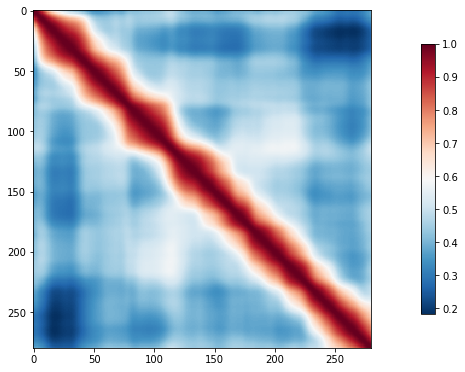

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

all_cosine_sim = []
for slFC in all_FC_sl: # subjects
    #windows
    cur_sim = cosine_similarity(slFC)
    all_cosine_sim.append(cur_sim)
    #plt.imshow(cur_sim,cmap=plt.cm.hot)
    #plt.show()
    
    
all_cosine_sim = np.stack(all_cosine_sim)

plotting.plot_matrix(all_cosine_sim[0])


In [46]:
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import AffinityPropagation

#all_cosine_sim[0]

affprop = AffinityPropagation(affinity = "precomputed", damping = 0.5)
affprop.fit(all_cosine_sim[0])

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [48]:
def embedding(similarity, sub):
    #dbscan = DBSCAN(metric = "euclidean").fit_predict(all_cosine_sim[0])
    FC_lowdim = manifol.fit_transform(all_cosine_sim[0])
    plt.scatter(FC_lowdim[:,0], FC_lowdim[:,1], alpha = 0.5)
    #plt.title(allid[i])
    plt.colorbar()

    plt.show()

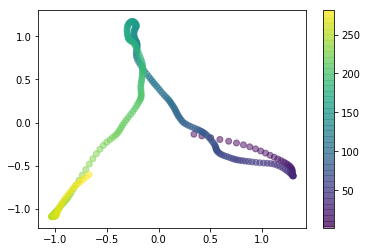

In [66]:
#scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 


embeddings = SpectralEmbedding(affinity='precomputed').fit_transform(all_cosine_sim[0])

plt.scatter(embeddings[:,0], embeddings[:,1], alpha = 0.5, c = (np.asarray(range(280)) + 2), cmap = 'viridis')

plt.colorbar()

plt.show()

In [35]:
all_FC_sl.shape

(1, 280, 264, 264)

In [25]:
def sliding_window_1d(a,ws=60,ss=1):
    """
    Parameters
    ----------
    a:  array , 1-D (n_volumes)
    ws: window width
    ss: window step size, in samples. If not provided, window and step size are equal.
    
    Returns
    ----------
    out : array-like , 2-D (n_windows,ws)
          Vector with all sliding windows
    """ 
    if None is ss:
    # no step size was provided. Return non-overlapping windows
        ss = ws   
    # calculate the number of windows to return, ignoring leftover samples, and
    # allocate memory to contain the samples
    valid = len(a) - ws
    
    nw = abs((valid) // ss)
    
    out = np.ndarray((nw,ws),dtype = a.dtype)
    
    for i in range(nw):
        
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]
    
    return out

In [26]:
def taper(window, ws = 60, wtype='tukey'):
    """
    Parameters
    ----------
    window : array-like , array of sliding window indices 
    ws: window width
    wtype: type of tapering function ( default : Tukey )
    
    Returns
    -------
    out :
    
    """
    if wtype == 'tukey':
        taper= scipy.signal.tukey(ws,alpha=0.5,sym=True)
    ## Removing the average value before tapering (to avoid spurious correlations at the beginning and end of the windows)
    window = window - np.mean(window)
    out = window*taper
    
    return out


In [27]:
def dfc_slid_window(X,ws,ss=1): 
        """
        Computes Sliding-window time-series per subject per region.
        Applies a Tukey window for tapering 
        
        Parameters
        ----------
        X: {array-like}, shape = (n_subjects , n_volumes , n_regions)
           resting state BOLD time-series for subjects
        ws : Window size 
        ss: Sliding step size (default=1)
        
        Returns
        -------
        slwin_ts : Array-like (n_subjects,n_windows,ws,n_regions)
        """
        nsubj=X.shape[0] # number of subjects
        nvolm=X.shape[1] # number of volumes
        nfeat=X.shape[2] # number of brain regions   
        slwin_ts=np.ndarray((nsubj,np.int16(np.ceil((nvolm-ws)//ss)),ws,nfeat))
        for idx,s in enumerate(X):
            fulltimewin = np.arange(nvolm,dtype='int32')
            swins= sliding_window_1d(a=fulltimewin,ws=ws,ss=ss)
            n_slwin = swins.shape[0] #number of sliding windows
            slwin_ts[idx]=np.empty((n_slwin,ws,nfeat))
            for n, curwin in enumerate(swins):
                cur_ts = s[curwin,:]
                slwin_ts[idx][n]=np.ndarray((ws,nfeat))
                for i in range(nfeat):
                    slwin_ts[idx][n][:,i]= taper(cur_ts[:,i],ws)
        return slwin_ts,slwin_ts.shape[1]